In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3)

20

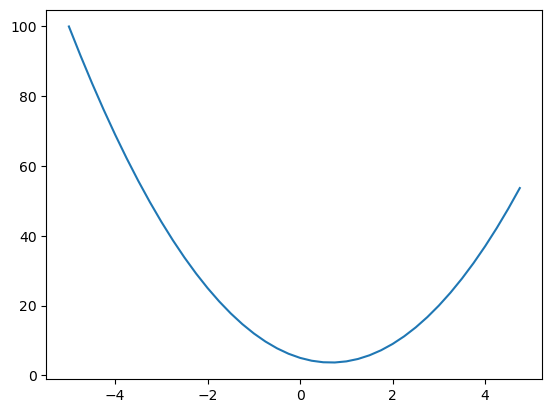

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)
plt.show()

In [5]:
#defining derevative of a function
h = 0.000001
x = 2/3
# finding derevative
(f(x+h) - f(x))/h

2.999378523327323e-06

In [6]:
#more complex
a= 2.0
b= -3.0
c= 10.0
d = a*b +c
print(d)

4.0


In [7]:
h= 0.000001

#inputs
a= 2.0
b= -3.0
c= 10.0

d1 = a*b +c
a+=h
d2 = a*b +c

print('d1=',d1)
print('d2=', d2)
print('slope=',(d2-d1)/h)

d1= 4.0
d2= 3.9999969999999996
slope= -3.000000000419334


In [8]:
h= 0.000001

#inputs
a= 2.0
b= -3.0
c= 10.0

d1 = a*b +c
b+=h
d2 = a*b +c

print('d1=',d1)
print('d2=', d2)
print('slope=',(d2-d1)/h)

d1= 4.0
d2= 4.000002
slope= 2.000000000279556


In [9]:
h= 0.000001

#inputs
a= 2.0
b= -3.0
c= 10.0

d1 = a*b +c
c+=h
d2 = a*b +c

print('d1=',d1)
print('d2=', d2)
print('slope=',(d2-d1)/h)

d1= 4.0
d2= 4.000000999999999
slope= 0.9999999992515995


As neural networks are massive expressions mathematically, we need some data structures to maintain these expressions.

#### Building the Value object

- In Python, the __repr__() method is a special method used to define the string representation of an object. It's called by the built-in repr() function and is meant to provide a more detailed and unambiguous representation of the object, often suitable for debugging or development purposes.
- **What it does:**
- Returns a string: The __repr__() method must return a string that represents the object.
- Provides a complete representation: The string returned should ideally be a valid Python expression that can be used to recreate the object. This is not always possible, but it's a good guideline. 
- Used for debugging: The __repr__() method is primarily used for debugging and development, allowing developers to easily inspect the state of an object.

In [126]:
class Value:
    #self is the current node, other is the 2nd variable during the operation and out is the output of the operation
    # to keep track of what velues produce what other values we define the _children() variable which will be a tuple, will be further used to calculate gradients for backpropagation ig
    # now we have the children which tells us what values created the result but we dont have whar operation resulted in the values, to know that we use another variable called _op
    # will maintain a variable for gradient called grad which will store the derevative of L with respect to the current Value.data
    def __init__(self, data, _children=(), _op='', label='' ):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda:None
        self._op=_op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"  

    #add method to add two value objects using dunder methods to define the operators of the classes' objects and then we use + operator python will internally call a.__add__(b)
    def __add__(self, other):
        #we have to make the Value object work with iteger additions too like a= Value(1) , a+1 should return a value object with data=2
        #check if other is an ineger , if yes then wrap it using the Value object
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self,other), '+') #to keep track of the previous operations we feed in the current Value i.e. self and other Value to the _children variable
        #the _op variable for addition operation will be +
        #now as we know that add will propagate the same gradient backwards we define the _backward function to perform the same
        def _backward():
            #to avoid the bug during multivariate chain rule we have to accumulate the gradients instead of setting them
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 
        return out   
    
    #multiply method to multiply two objects using dunder methods as before.
    def __mul__(self, other):
        #check if other is an ineger , if yes then wrap it using the Value object
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self,other), '*')

        #similar to addition we define the backpropagation function for when the operation is multiplication to propagate the gradients to self and other
        def _backward():
            #to avoid the bug during multivariate chain rule we have to accumulate the gradients instead of setting them
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    #now python will get confused if we write 2 * a as python doesnt know if 2 is a Value object or not, for which we need to use __rmul__ function
    def __rmul__(self, other):
        return self * other

    #as a special case of exponentiation a/b can be rewritten as a * (b **-1)
    def __truediv__(self, other):
        return self * other ** -1 #now we have to define exponentiation method for Value
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        #assert keyword in Python is a tool that evaluates the validity of a statement
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward=_backward
        return out    


    #instead of Implementing all the atomic pieces of tanh like exponentiation function we can directly implement the abstraction of tanh
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) +1)
        out = Value(t, (self, ),'tanh')

        #we also need to dfine the backpropagation step for the tanh so that the gradient propagates throught the tanh activation funtion
        def _backward():
            #to avoid the bug during multivariate chain rule we have to accumulate the gradients instead of setting them
            self.grad += (1-t**2) * out.grad
        out._backward = _backward

        return out
    


    #for the exponentiation implementation
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ),'exp')

        #for calculating the backpropagated value for the exponentiation function
        def _backward():
            self.grad += out.data * out.grad
        out._backward= _backward    
        return out

    #instead of calling the tpoplogical sort and doing backpropagation there we can define a backward method which can be called and then with a single line we can do backpropagation of gradient
    #function for topological sort
    def backward(self):
        topo =[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        #first we have to set o.grad to be 1.0 to avoid null propagation
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [113]:
a= Value(1.0)
b= Value(2.0)
a-b

Value(data=-1.0)

In [11]:
a = Value(2.0 , label = 'a')
b = Value(-3.0 , label= 'b')
c = Value(10.0, label='c')
e= a*b; e.label='e'
d = e + c; d.label = 'd' #equivalent to (a.__mul__(b)).__add__(c)
f = Value(-2.0, label='f')
L = d*f; L.label= 'L'
L

Value(data=-8.0)

In [43]:
#we use graphviz's api to visualize the above operations
from graphviz import Digraph

# trace is a helper function that enumerates all the nodes in the graph
def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes , edges = set() ,set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child , v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'})  #LR here means Left to Right

    nodes, edges = trace(root)
    #iterate through all the nodes and create special objects for them using .node and .edges for edges
    for n in nodes:
        uid = str(id(n))
        # for  any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid , label ='{ %s | data %.4f | grad %.4f }' % (n.label , n.data, n.grad), shape = 'record')
        if n._op:
          dot.node(name = uid + n._op, label = n._op)
          #connect this node to it
          dot.edge(uid + n._op , uid)

    for n1,n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot                 

In [13]:
# now for backpropagation we manually set the base case that is gradient of L with respect to L is 1 so,
L.grad=1.0

In [14]:
# we manually calculate gradients for dL/dd and dL/df which are the values of f and d respectively i.e. -2.0 and 4.0 respectively
f.grad = 4.0
d.grad = -2.0

In [15]:
# now to calculae the gradient of node c with respect to L , using the chain rule of derecatives we can say that dL/dc = dL/dd * dd/dc
c.grad = d.grad * 1.0 #because dd/dc = 1.0

In [16]:
#for derevative of L w.r.t e , using the chain rule of derevatives we can say that dL/de = dL/dd * dd/de
e.grad = d.grad * 1.0 #because dd/de = 1.0

we can observe that the + node's derevative is basically copied along to the previous dependent nodes as the local derevative always becomes 1.

In [17]:
#now going even backwards to find the derevative of node L w.r.t b i.e dL/db = dL/dd * dd/de * de/db
b.grad = e.grad * a.data
b.grad

-4.0

In [18]:
#similarly we find the value of dL/da = dL/dd * dd/de * de/da
a.grad = e.grad * b.data
a.grad

6.0

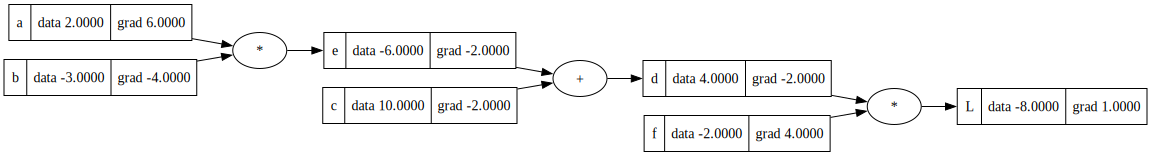

In [19]:
draw_dot(L)

In [21]:
#changing the input values so that L increases
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d* f
print(L.data)

-7.286496


In [20]:
def lol():

    h=0.00001

    a = Value(2.0 , label = 'a')
    b = Value(-3.0 , label= 'b')
    c = Value(10.0, label='c')
    e= a*b; e.label='e'
    d = e + c; d.label = 'd' #equivalent to (a.__mul__(b)).__add__(c)
    f = Value(-2.0, label='f')
    L = d*f; L.label= 'L'
    L1 = L.data
    # L1 = c.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0 , label= 'b')
    b.data+=h
    c = Value(10.0, label='c')
    e= a*b; e.label='e'
    d = e + c; d.label = 'd' #equivalent to (a.__mul__(b)).__add__(c)
    f = Value(-2.0, label='f')
    L = d*f; L.label= 'L'
    L2 = L.data
    # L2 = c.data

    print((L2-L1)/h)
lol()    

-4.000000000026205


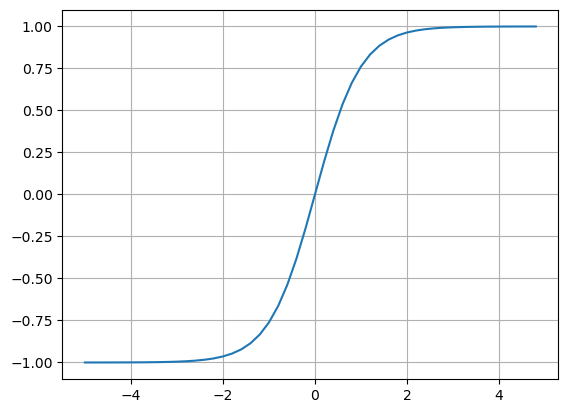

In [23]:
# visualizing tanh
plt.plot(np.arange(-5,5,0.2) , np.tanh(np.arange(-5,5,0.2)))
plt.grid()

## Deifining a neuron structure

In [83]:
#building up a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#initializing the weights for the neuron
w1 = Value( -3.0, label ='w1')
w2 = Value( 1.0, label ='w2')

#initializing bias for the neuron
b = Value(6.8813735870195432 , label='b')

#output = w1x1 + w2x2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#output n
n = x1w1x2w2 + b ; n.label='n'

#pass through activation fxn
# we have to implement tanh in the Value definition , tanh is an hyperbolic function
o = n.tanh() ; o.label='o'

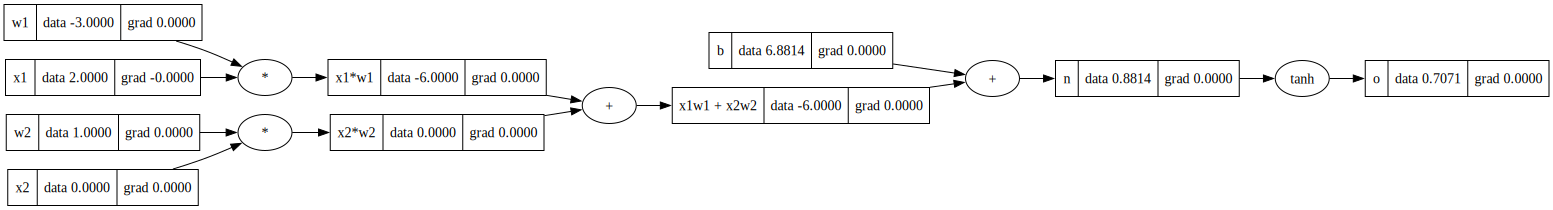

In [58]:
draw_dot(o)

## Manual Backpropagation

In [ ]:
#building up a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#initializing the weights for the neuron
w1 = Value( -3.0, label ='w1')
w2 = Value( 1.0, label ='w2')

#initializing bias for the neuron
b = Value(6.8813735870195432 , label='b')

#output = w1x1 + w2x2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#output n
n = x1w1x2w2 + b ; n.label='n'

#pass through activation fxn
# we have to implement tanh in the Value definition , tanh is an hyperbolic function
o = n.tanh() ; o.label='o'

#calculating the backprop values
o.backward()

In [47]:
#backpropagation to update the gradients
#for gradient of o do/do = 1
o.grad = 1.0

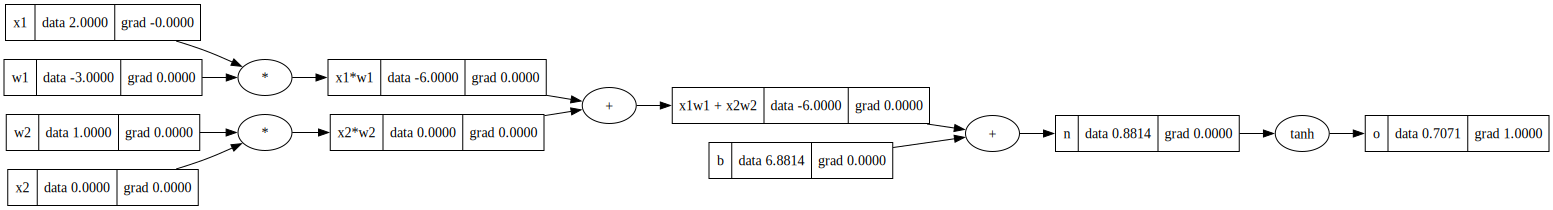

In [48]:
draw_dot(o)

In [49]:
#for do/dn we need derevative of tanh , i.e. 1-(tanh)**2
n.grad = 1 - (o.data)**2


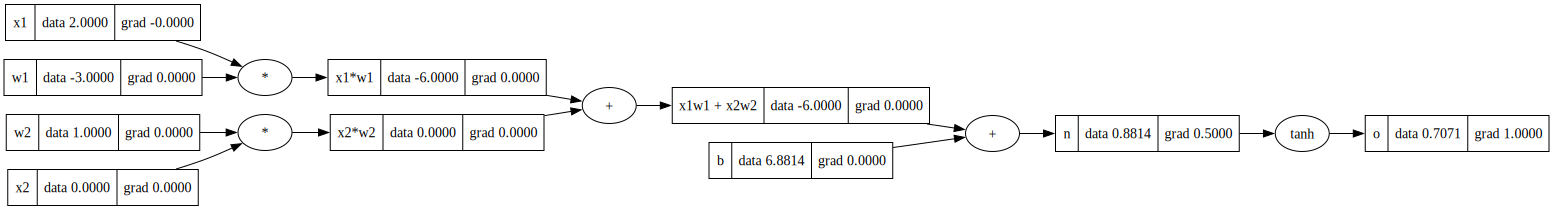

In [50]:
draw_dot(o)

In [51]:
#as we noticed previously the + operation will simple propagate the gradient to the backward connected nodes
x1w1x2w2.grad = n.grad *1
b.grad = n.grad *1

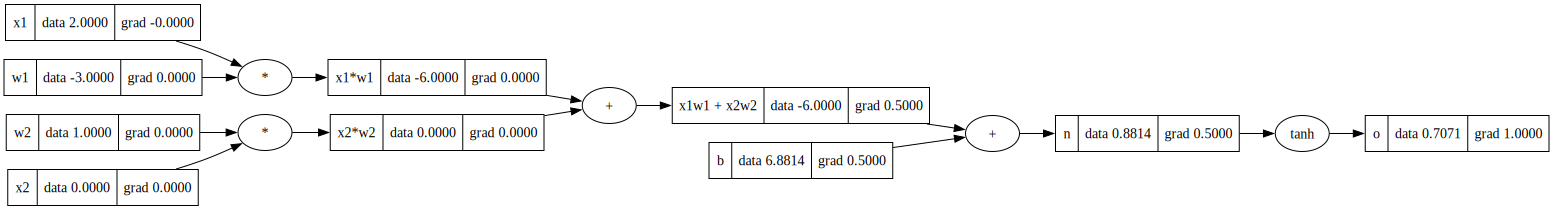

In [52]:
draw_dot(o)

In [53]:
#similarly for the gradient of x1w1 and x2w2 the + sign will simply propagate the gradient backwards
x1w1.grad = x1w1x2w2.grad *1
x2w2.grad = x1w1x2w2.grad *1

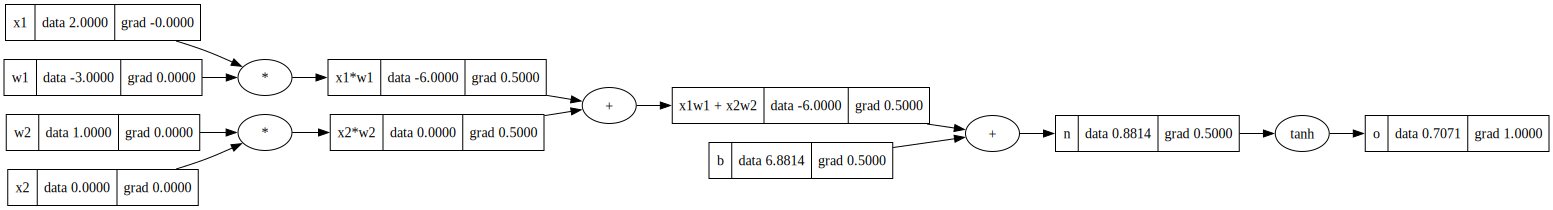

In [54]:
draw_dot(o)

In [55]:
#for w1 w2 x1 and x2 we have to calculate the gradients 
# for x2 , do/dx2 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx2w2 * dx2w2/dx2
x2.grad = x2w2.grad * w2.data #as x2w2.grad = (o.grad * n.grad * x1w1x2w2.grad )
#similarly for w2.grad
w2.grad = x2.data * x2w2.grad
#now for x1.grad
x1.grad = w1.data * x1w1.grad
#for w1.grad
w1.grad = x1.data * x1w1.grad

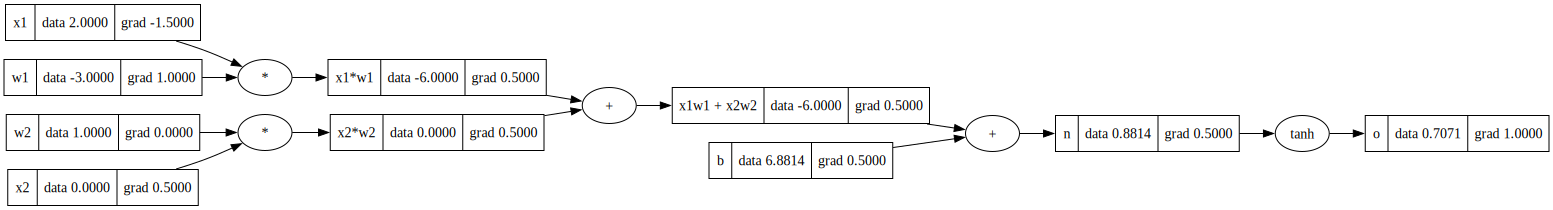

In [56]:
draw_dot(o)

## Automatic Backpropagation (calling the _backward() method manually on each node)

In [ ]:
#building up a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#initializing the weights for the neuron
w1 = Value( -3.0, label ='w1')
w2 = Value( 1.0, label ='w2')

#initializing bias for the neuron
b = Value(6.8813735870195432 , label='b')

#output = w1x1 + w2x2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#output n
n = x1w1x2w2 + b ; n.label='n'

#pass through activation fxn
# we have to implement tanh in the Value definition , tanh is an hyperbolic function
o = n.tanh() ; o.label='o'

#calculating the backprop values
o.backward()

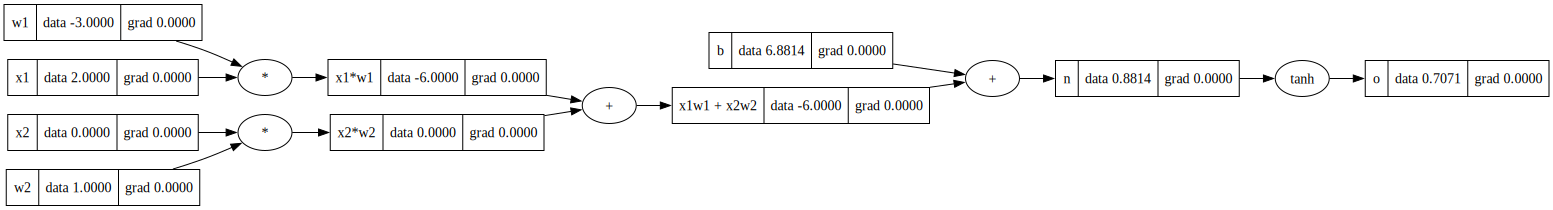

In [65]:
draw_dot(o)

In [66]:
o.grad = 1.0

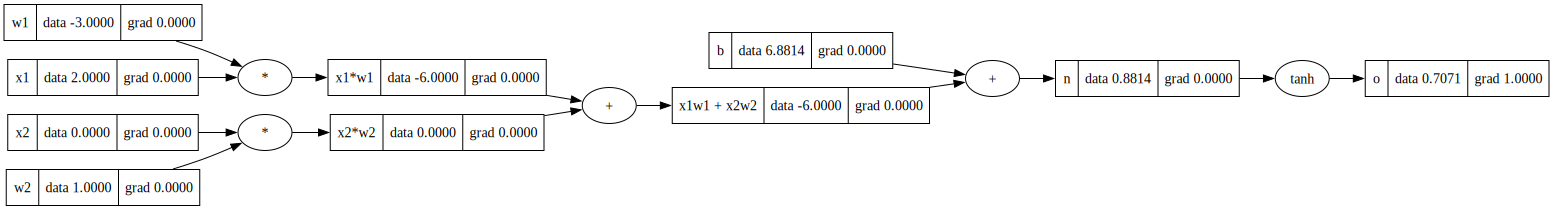

In [67]:
draw_dot(o)

In [68]:
o._backward()

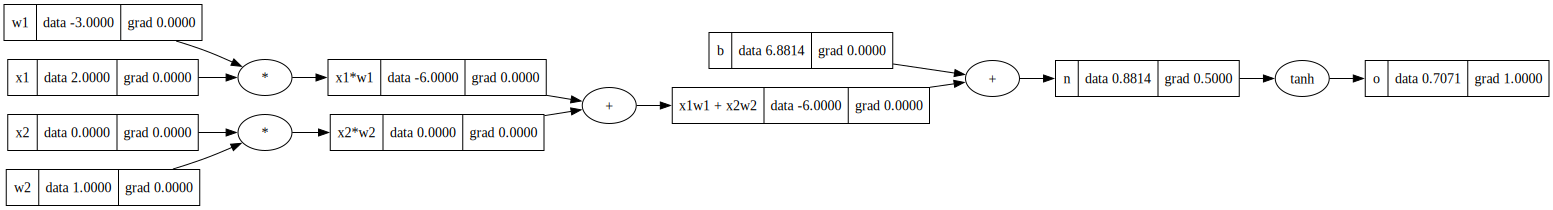

In [69]:
draw_dot(o)

In [70]:
n._backward()

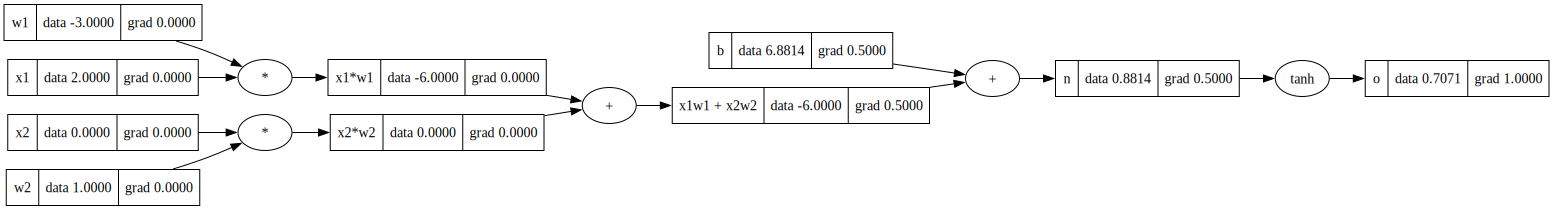

In [71]:
draw_dot(o)

In [72]:
x1w1x2w2._backward()

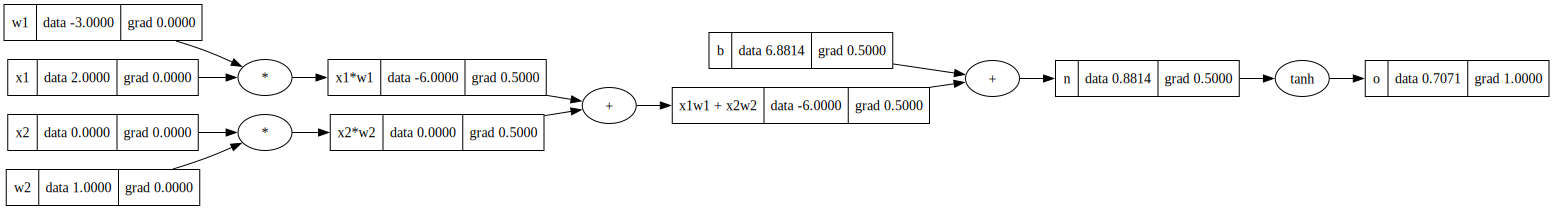

In [73]:
draw_dot(o)

In [74]:
x2w2._backward()
x1w1._backward()

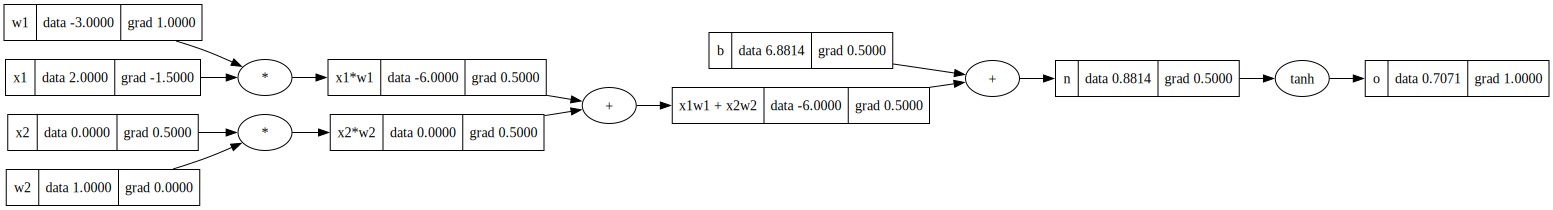

In [75]:
draw_dot(o)

### To make sure that the gradients at the current node are finished calculating before the gradients for the backward nodes start getting calculated , we need to get a topologically sorted graph for the nodes available currently
- Topological sort: making it so that all the edges point in only one direction

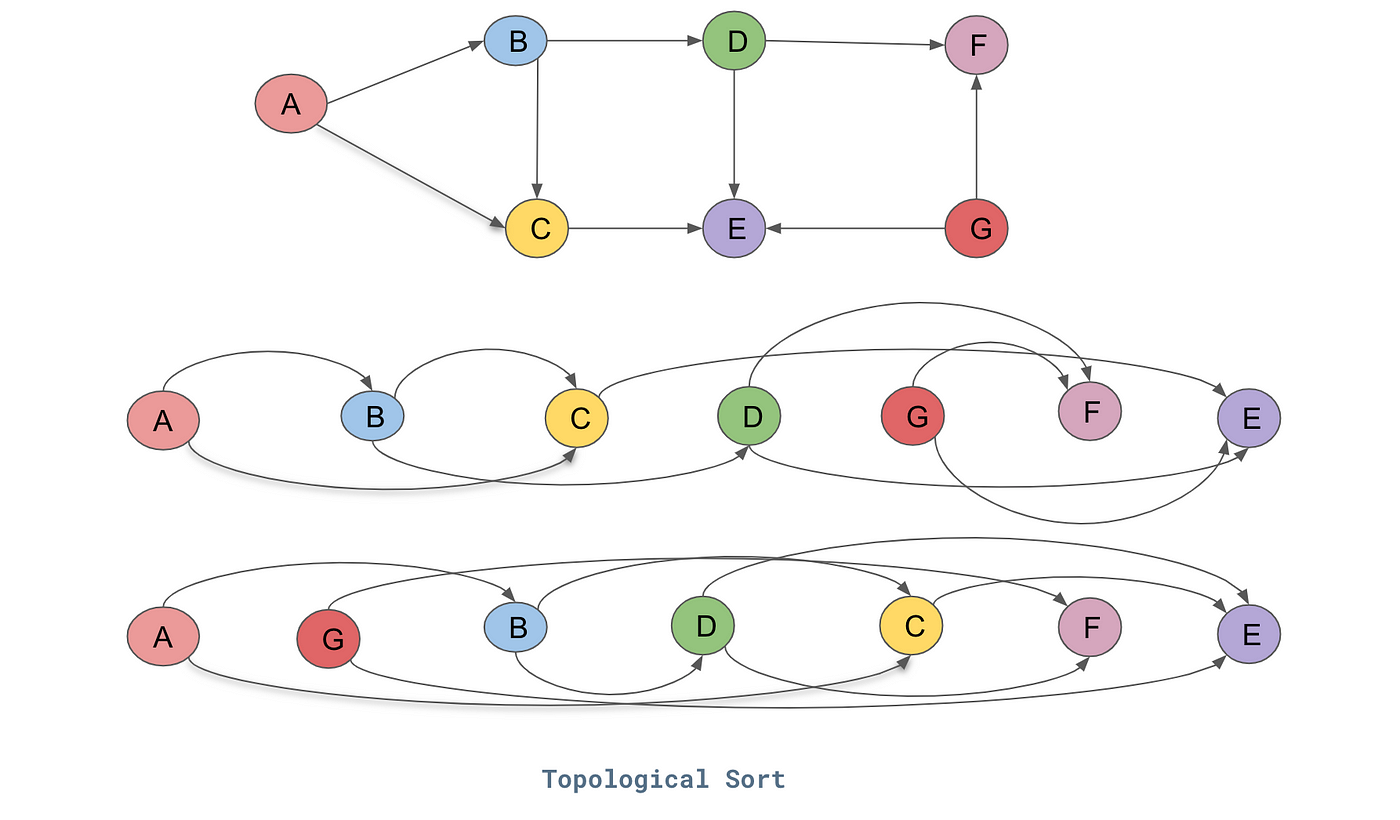

works on the principle of you are going to be in the list once all your children are in the list

In [76]:
#function for topological sort
topo =[]
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo            

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

## Automatic backpropagation using topologically sorted nodes

In [ ]:
#building up a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#initializing the weights for the neuron
w1 = Value( -3.0, label ='w1')
w2 = Value( 1.0, label ='w2')

#initializing bias for the neuron
b = Value(6.8813735870195432 , label='b')

#output = w1x1 + w2x2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#output n
n = x1w1x2w2 + b ; n.label='n'

#pass through activation fxn
# we have to implement tanh in the Value definition , tanh is an hyperbolic function
o = n.tanh() ; o.label='o'

#calculating the backprop values
o.backward()

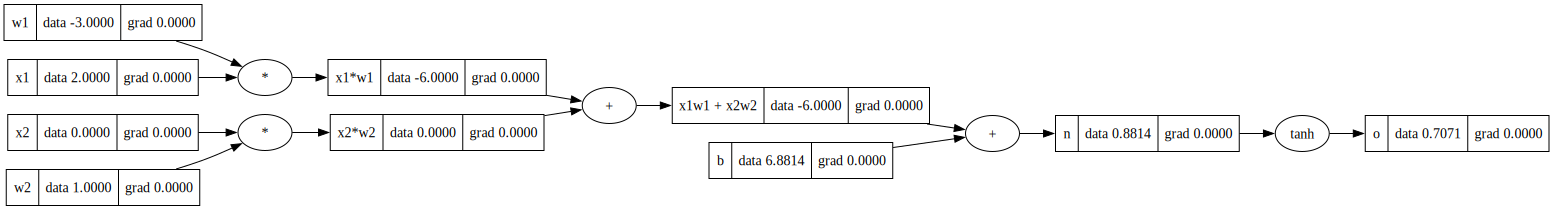

In [78]:
draw_dot(o)

In [79]:
o.grad = 1.0

In [80]:
#function for topological sort
topo =[]
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

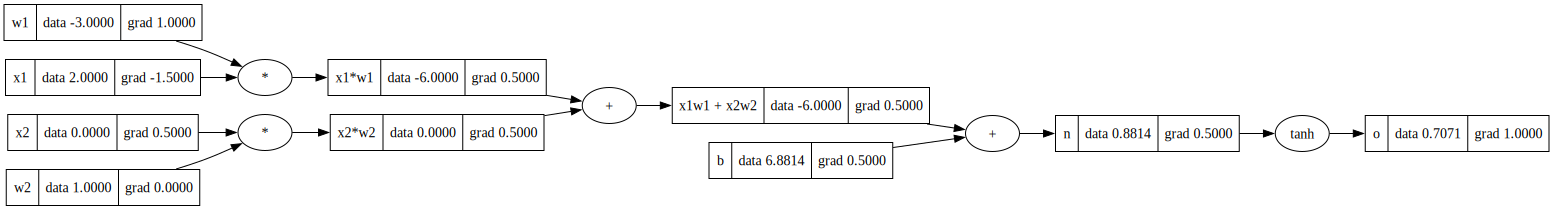

In [81]:
draw_dot(o)

## Backpropagation using the defined backward() method instead of calling it outside

In [ ]:
#building up a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#initializing the weights for the neuron
w1 = Value( -3.0, label ='w1')
w2 = Value( 1.0, label ='w2')

#initializing bias for the neuron
b = Value(6.8813735870195432 , label='b')

#output = w1x1 + w2x2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#output n
n = x1w1x2w2 + b ; n.label='n'

#pass through activation fxn
# we have to implement tanh in the Value definition , tanh is an hyperbolic function
o = n.tanh() ; o.label='o'

#calculating the backprop values
o.backward()

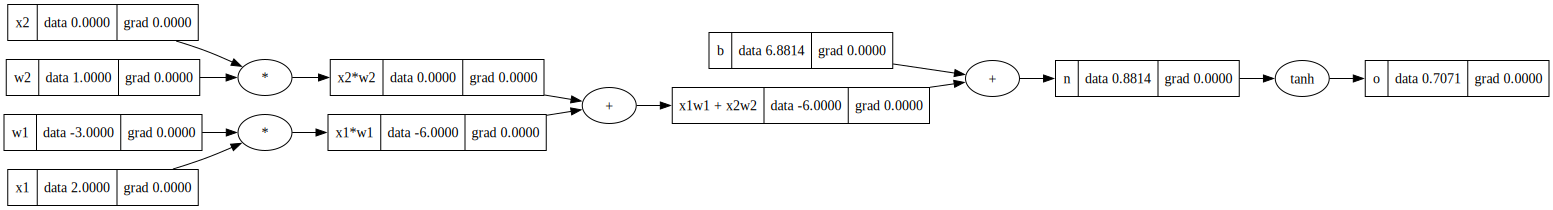

In [84]:
draw_dot(o)

In [85]:
o.backward()

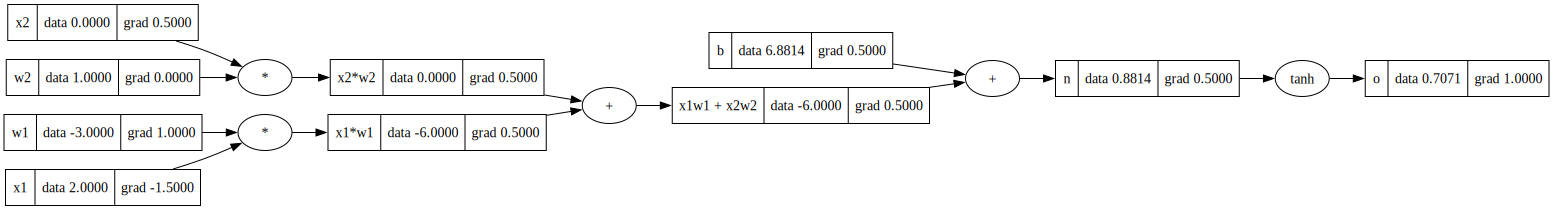

In [86]:
draw_dot(o)

#### now there's a bug in this that for a neuron with one node the backprop will propagate the same value 1 of the output node and not calculate the gradient

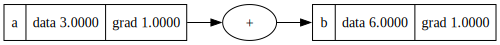

In [87]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

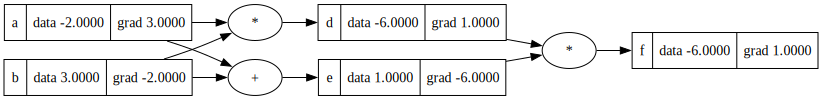

In [89]:
#another example
a = Value(-2.0 , label='a')
b = Value(3.0 , label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

problem is that whenever we use a variable more than two times for imput of nodes the gradients at the intermediary steps get overwritten with the new calculated gradients instead of gettin combined with them

solution : to accumulate the gradients instead of setting them again

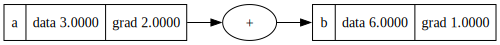

In [91]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

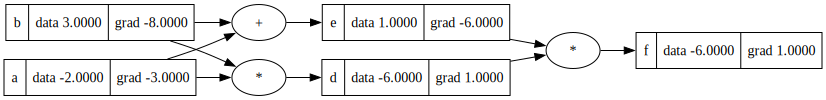

In [92]:
#another example
a = Value(-2.0 , label='a')
b = Value(3.0 , label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

## Breaking tanh atomically into singular expression funcitons

In [114]:
#building up a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#initializing the weights for the neuron
w1 = Value( -3.0, label ='w1')
w2 = Value( 1.0, label ='w2')

#initializing bias for the neuron
b = Value(6.8813735870195432 , label='b')

#output = w1x1 + w2x2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#output n
n = x1w1x2w2 + b ; n.label='n'

#pass through activation fxn
# we have to implement tanh in the Value definition , tanh is an hyperbolic function
o = n.tanh() ; o.label='o'

#calculating the backprop values
o.backward()

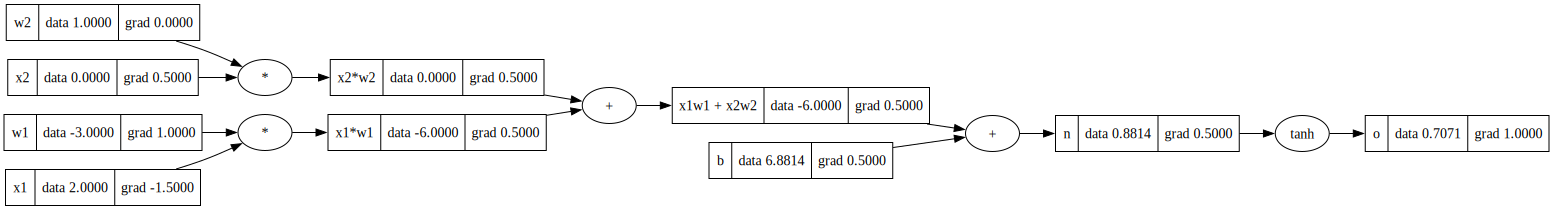

In [115]:
draw_dot(o)

In [127]:
#building up a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#initializing the weights for the neuron
w1 = Value( -3.0, label ='w1')
w2 = Value( 1.0, label ='w2')

#initializing bias for the neuron
b = Value(6.8813735870195432 , label='b')

#output = w1x1 + w2x2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#output n
n = x1w1x2w2 + b ; n.label='n'

#pass through activation fxn
# we have to implement tanh in the Value definition , tanh is an hyperbolic function
e = (2*n).exp()
o= (e - 1)/(e + 1) ; o.label='o'

#calculating the backprop values
o.backward()

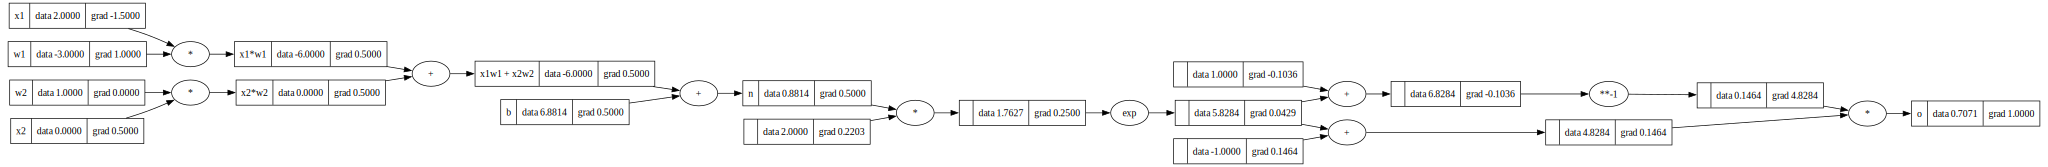

In [128]:
draw_dot(o)

## Same thing but using PyTorch

In [132]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.5.1%2Bcu118-cp312-cp312-win_amd64.whl (2700.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.20.1%2Bcu118-cp312-cp312-win_amd64.whl (5.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.5.1%2Bcu118-cp312-cp312-win_amd64.whl (4.0 MB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [133]:
import torch

In [134]:
#value objects can be viewed as Tensors in Pytorch library
#In reality tensors are n-dimensional arrays of scalars
# by default python uses the int32 format for casting the integers, for more prescision and consistence we are using the .double() method to typecast to float64
x1 = torch.Tensor([2.0]).double()                   ;x1.requires_grad = True #as they are leaf nodes pytorch assumes that they dont need gradients, so we need to explicitly mention that we need gradients for the leaf nodes too
x2 = torch.Tensor([0.0]).double()                   ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ;b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
#we need to specift .item() because by default pytorch will return the object by sripping out the Tensor part from the torch.Tensor node
print(o.data.item())
o.backward()

print('----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('b',b.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
b 0.5000001283844369
